In [ ]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Utilidades generales
import time
import os
from itertools import combinations

# Visualización
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import plotly.graph_objects as go

# Algoritmos y matrices
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

Preprocesamiento y limpieza de datasets

In [ ]:
#Cargar datases
orders= pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')

# Limpieza de la base de datos
products['product_name'] = products['product_name'].replace(
    to_replace="[^a-zA-Z\\d\\s]+",
    value="~",
    regex=True
).str.lower().str.strip()



In [ ]:
# Mege y agrupación por No de  orden
dfMerged = pd.merge(orders, products, on="product_id", how="inner")
dfMerged = dfMerged.sort_values("order_id").reset_index(drop=True)

# Agrupar productos por transacción (cada pedido (order_id) se agrupa en una lista de productos)
transactions = dfMerged.groupby('order_id')['product_name'].apply(list).tolist()

for t in transactions[:5]:
    print(t)


['bulgarian yogurt', 'organic 4~ milk fat whole milk cottage cheese', 'cucumber kirby', 'organic celery hearts', 'lightly smoked sardines in olive oil', 'organic hass avocado', 'bag of organic bananas', 'organic whole string cheese']
['grated pecorino romano cheese', 'spring water', 'super greens salad', 'cage free extra large grade aa eggs', 'prosciutto~ americano', 'organic garnet sweet potato ~yam~', 'asparagus', 'organic half ~ half']
['shelled pistachios', 'organic raw unfiltered apple cider vinegar', 'organic hot house tomato', 'organic baby arugula', 'green peas', 'bunched cilantro', 'flat parsley~ bunch', 'organic biologique limes', 'fresh dill']
['organic raspberries', 'organic whole strawberries', 'organic blueberries', 'organic grape tomatoes', 'organic cucumber', 'roasted turkey', 'organic pomegranate kernels']
['natural spring water', 'organic unsweetened almond milk', 'tomatoes~ crushed~ organic', 'organic sliced provalone cheese', 'organic chocolate almondmilk pudding', 

In [ ]:
# Exportando las transacciones a CSV (formato basket) para su uso posterior en R.

output_csv = "TransactionsInstacart.csv"
with open(output_csv, "w", newline="", encoding="utf-8") as f:
    for trans in transactions:
        f.write(",".join(trans) + "\n")
print(f"Transacciones exportadas a '{output_csv}'.")


Transacciones exportadas a 'TransactionsInstacart.csv'.


Creacion de Martiz dispersa

In [ ]:
# Se crea un mapeo de cada producto a un índice.
item_mapping = {item: idx for idx, item in enumerate(sorted({item for transaction in transactions for item in transaction}))}

# Recorremos cada transacción para construir las coordenadas (filas y columnas) en la matriz.
rows, cols = [], []
for row_idx, trans in enumerate(transactions):
    for item in trans:
        rows.append(row_idx)
        cols.append(item_mapping[item])

order_matrix_sparse = csr_matrix(([1] * len(rows), (rows, cols)), shape=(len(transactions), len(item_mapping)))
print(f"Matriz dispersa creada con forma: {order_matrix_sparse.shape}")

Matriz dispersa creada con forma: (131209, 39043)


In [ ]:
# Convertir la matriz dispersa a una lista de transacciones (lista de productos comprados)
transactions_list = []
for row in order_matrix_sparse:
    non_zero_indices = row.nonzero()[1]  # Encuentra los índices no cero
    transaction = [list(item_mapping.keys())[index] for index in non_zero_indices]
    transactions_list.append(transaction)

Implementación Manual del Algoritmo Apriori en Python (Procesamiento por Lotes)

In [ ]:
def generar_candidatos(itemsets_frecuentes_k, k, max_candidates=100000, support_dict=None):
    """
    Genera candidatos (k+1)-itemsets a partir de itemsets frecuentes de tamaño k.
    Aplica límites si hay demasiados itemsets y usa un índice por prefijo para mayor eficiencia.
    """
    if len(itemsets_frecuentes_k) > 1000:
        print(f"Demasiados itemsets frecuentes ({len(itemsets_frecuentes_k)}). Limitando a los 1000 más frecuentes.")
        if support_dict:
            itemsets_frecuentes_k = sorted(itemsets_frecuentes_k,
                                           key=lambda x: support_dict.get(tuple(x), 0),
                                           reverse=True)[:1000]
        else:
            itemsets_frecuentes_k = itemsets_frecuentes_k[:1000]

    n = len(itemsets_frecuentes_k)
    estimated_candidates = n * (n - 1) // 2
    if estimated_candidates > max_candidates:
        reduction_factor = max_candidates / estimated_candidates
        limit = int(n * (reduction_factor ** 0.5))
        print(f"Estimación de candidatos ({estimated_candidates}) excede el máximo. Limitando a {limit} itemsets.")
        if support_dict:
            itemsets_frecuentes_k = sorted(itemsets_frecuentes_k,
                                           key=lambda x: support_dict.get(tuple(x), 0),
                                           reverse=True)[:limit]
        else:
            itemsets_frecuentes_k = itemsets_frecuentes_k[:limit]
        n = len(itemsets_frecuentes_k)

    candidatos_set = set()
    if k == 1:
        for i in range(n):
            for j in range(i+1, n):
                candidato = tuple(sorted([itemsets_frecuentes_k[i][0], itemsets_frecuentes_k[j][0]]))
                candidatos_set.add(candidato)
    else:
        # Crear índice por prefijo (los primeros k-1 elementos)
        prefix_index = {}
        for idx, itemset in enumerate(itemsets_frecuentes_k):
            prefix = tuple(itemset[:k-1])
            prefix_index.setdefault(prefix, []).append(idx)
        for prefix, indices in prefix_index.items():
            if len(indices) > 1:
                for i in range(len(indices)):
                    for j in range(i+1, len(indices)):
                        idx1, idx2 = indices[i], indices[j]
                        candidato = list(prefix) + [itemsets_frecuentes_k[idx1][k-1],
                                                    itemsets_frecuentes_k[idx2][k-1]]
                        candidato.sort()
                        candidatos_set.add(tuple(candidato))

    candidatos_unicos = [list(x) for x in candidatos_set]
    if len(candidatos_unicos) > max_candidates:
        print(f"Aún hay demasiados candidatos ({len(candidatos_unicos)}). Limitando a {max_candidates}.")
        candidatos_unicos = candidatos_unicos[:max_candidates]

    return candidatos_unicos

#Optimización en lugar de usar sorted en cada iteración dentro de all , se preordenan los candidatos y se optimiza la comparación
def poda_apriori(candidatos, itemsets_frecuentes_k, k):
    """
    Poda candidatos eliminando aquellos cuyo subconjunto (de tamaño k) no es frecuente.
    """
    itemsets_frecuentes_set = set(tuple(sorted(x)) for x in itemsets_frecuentes_k)  # Preordena los itemsets frecuentes
    candidatos_podados = [candidato for candidato in candidatos if all(tuple(sorted(candidato[:i] + candidato[i+1:])) in itemsets_frecuentes_set for i in range(len(candidato)))]
    return candidatos_podados

def apriori_lotes(transactions_list, min_support, batch_size=50000):
    """
    Implementación manual del algoritmo Apriori usando procesamiento por lotes.
    Calcula 1-itemsets y itemsets de mayor tamaño, usando un diccionario para los soportes.
    """
    n_total = len(transactions_list)
    print(f"Procesando {n_total} transacciones con soporte mínimo {min_support}")

    # Fase 1: Contar 1-itemsets en lotes
    item_counts = {}
    n_batches = (n_total + batch_size - 1) // batch_size
    print(f"Fase 1: Generando 1-itemsets frecuentes en {n_batches} lotes.")
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_total)
        print(f"  Procesando lote {i+1}/{n_batches} (transacciones {start_idx} - {end_idx})")
        batch_transactions = transactions_list[start_idx:end_idx]
        for transaction in batch_transactions:
            for item in transaction:
                item_counts[item] = item_counts.get(item, 0) + 1

    frequent_1_itemsets = []
    support_dict = {}
    for item, count in item_counts.items():
        support = count / n_total
        if support >= min_support:
            frequent_1_itemsets.append([item])
            support_dict[tuple([item])] = support
    print(f"Se encontraron {len(frequent_1_itemsets)} 1-itemsets frecuentes.")

    all_frequent_itemsets = {1: frequent_1_itemsets}
    k = 1
    while all_frequent_itemsets.get(k, []):
        print(f"Fase {k+1}: Generando {k+1}-itemsets frecuentes.")
        if len(all_frequent_itemsets[k]) > 1000:
            print(f"  Demasiados itemsets frecuentes ({len(all_frequent_itemsets[k])}). Limitando a 1000 con mayor soporte.")
            sorted_itemsets = sorted(all_frequent_itemsets[k],
                                     key=lambda x: support_dict.get(tuple(x), 0),
                                     reverse=True)[:1000]
            all_frequent_itemsets[k] = sorted_itemsets

        candidatos = generar_candidatos(all_frequent_itemsets[k], k, support_dict=support_dict)
        if len(candidatos) > 100000:
            print(f"  Demasiados candidatos ({len(candidatos)}). Aumentando temporalmente el umbral de soporte.")
            temp_min_support = min_support * 2
            filtered_itemsets = [itemset for itemset in all_frequent_itemsets[k] if support_dict.get(tuple(itemset), 0) >= temp_min_support]
            candidatos = generar_candidatos(filtered_itemsets, k, support_dict=support_dict)

        candidatos_podados = poda_apriori(candidatos, all_frequent_itemsets[k], k)
        print(f"  Generados {len(candidatos)} candidatos, {len(candidatos_podados)} después de poda.")
        if not candidatos_podados:
            break

        # Contar soporte de candidatos en lotes
        candidato_counts = {tuple(c): 0 for c in candidatos_podados}
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_total)
            print(f"  Contando candidatos en lote {i+1}/{n_batches} (transacciones {start_idx} - {end_idx})")
            batch_transactions = transactions_list[start_idx:end_idx]
            for transaction in batch_transactions:
                transaction_set = set(transaction)
                for candidato in candidatos_podados:
                    if all(item in transaction_set for item in candidato):
                        candidato_counts[tuple(candidato)] += 1

        frequent_itemsets_k_plus_1 = []
        for candidato, count in candidato_counts.items():
            support = count / n_total
            if support >= min_support:
                frequent_itemsets_k_plus_1.append(list(candidato))
                support_dict[tuple(sorted(candidato))] = support

        print(f"  Se encontraron {len(frequent_itemsets_k_plus_1)} {k+1}-itemsets frecuentes.")
        if frequent_itemsets_k_plus_1:
            all_frequent_itemsets[k+1] = frequent_itemsets_k_plus_1
            k += 1
        else:
            break
    return all_frequent_itemsets, support_dict

def generar_reglas(itemsets_frecuentes, support_dict, min_confidence=0.3):
    """
    Genera reglas de asociación a partir de itemsets frecuentes.
    Para cada itemset (de tamaño >= 2), genera todas las posibles divisiones:
    antecedente y consecuente, calcula métricas (soporte, confianza, lift) y
    retorna un DataFrame con las reglas ordenadas por lift.
    """
    rules = []
    for k in range(2, len(itemsets_frecuentes) + 1):
        if k not in itemsets_frecuentes:
            continue
        for itemset in itemsets_frecuentes[k]:
            itemset_support = support_dict.get(tuple(sorted(itemset)), 0)
            for i in range(1, len(itemset)):
                for antecedente_items in combinations(itemset, i):
                    antecedente = list(antecedente_items)
                    consecuente = [item for item in itemset if item not in antecedente]
                    if not antecedente or not consecuente:
                        continue
                    antecedente_support = support_dict.get(tuple(sorted(antecedente)), 0)
                    if antecedente_support == 0:
                        continue
                    confidence = itemset_support / antecedente_support
                    if confidence >= min_confidence:
                        consecuente_support = support_dict.get(tuple(sorted(consecuente)), 0)
                        if consecuente_support == 0:
                            continue
                        lift = confidence / consecuente_support
                        rules.append({
                            'antecedent': antecedente,
                            'consequent': consecuente,
                            'support': itemset_support,
                            'confidence': confidence,
                            'lift': lift
                        })
    if rules:
        rulesDf = pd.DataFrame(rules)
        rulesDf = rulesDf.sort_values('lift', ascending=False).reset_index(drop=True)
        return rulesDf
    else:
        return pd.DataFrame(columns=['antecedent', 'consequent', 'support', 'confidence', 'lift'])



Ejecución de Apriori Manual

In [ ]:
# Ejecutar el algoritmo Apriori manual
min_support = 0.01
min_confidence = 0.3

# Aquí usamos la lista de transacciones obtenida antes
transactions_list = transactions

start_time = time.time()

all_frequent_itemsets, support_dict = apriori_lotes(transactions_list, min_support)

# Generar reglas a partir de los itemsets frecuentes
rules_manual = generar_reglas(all_frequent_itemsets, support_dict, min_confidence=0.3)
print("\nReglas generadas manualmente (primeras 5):")
print(rules_manual.head())


manual_time = time.time() - start_time
print(f"\nTiempo total del Apriori manual (itemsets + reglas): {manual_time:.2f} segundos")


print("\nReglas generadas manualmente (primeras 5):")
print(rules_manual.head())


Procesando 131209 transacciones con soporte mínimo 0.01
Fase 1: Generando 1-itemsets frecuentes en 3 lotes.
  Procesando lote 1/3 (transacciones 0 - 50000)
  Procesando lote 2/3 (transacciones 50000 - 100000)
  Procesando lote 3/3 (transacciones 100000 - 131209)
Se encontraron 104 1-itemsets frecuentes.
Fase 2: Generando 2-itemsets frecuentes.
  Generados 5356 candidatos, 5356 después de poda.
  Contando candidatos en lote 1/3 (transacciones 0 - 50000)
  Contando candidatos en lote 2/3 (transacciones 50000 - 100000)
  Contando candidatos en lote 3/3 (transacciones 100000 - 131209)
  Se encontraron 16 2-itemsets frecuentes.
Fase 3: Generando 3-itemsets frecuentes.
  Generados 22 candidatos, 7 después de poda.
  Contando candidatos en lote 1/3 (transacciones 0 - 50000)
  Contando candidatos en lote 2/3 (transacciones 50000 - 100000)
  Contando candidatos en lote 3/3 (transacciones 100000 - 131209)
  Se encontraron 0 3-itemsets frecuentes.

Reglas generadas manualmente (primeras 5):
     

Ejecución de Apriori con mlxtend

In [ ]:
# Convertir la lista de transacciones en formato binarizado para la librería
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Cronometrar todo el flujo de Apriori con mlxtend
start_time_mlxtend = time.time()

# Generar itemsets frecuentes
frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)

# Generar reglas de asociación
rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Detener el cronómetro
mlxtend_time = time.time() - start_time_mlxtend
print(f"\nTiempo total del Apriori con mlxtend (itemsets + reglas): {mlxtend_time:.2f} segundos")

# Mostrar resultados
print("\nItemsets frecuentes generados con mlxtend:")
print(frequent_itemsets.head())
print("\nReglas generadas con mlxtend (primeras 5):")
print(rules_mlxtend.head())



Tiempo total del Apriori con mlxtend (itemsets + reglas): 93.89 segundos

Itemsets frecuentes generados con mlxtend:
    support                    itemsets
0  0.017514    (100~ whole wheat bread)
1  0.011737       (2~ reduced fat milk)
2  0.017163  (apple honeycrisp organic)
3  0.029480                 (asparagus)
4  0.117980    (bag of organic bananas)

Reglas generadas con mlxtend (primeras 5):
                antecedents               consequents  antecedent support  \
0  (bag of organic bananas)    (organic baby spinach)            0.117980   
1    (organic baby spinach)  (bag of organic bananas)            0.074568   
2    (organic hass avocado)  (bag of organic bananas)            0.055583   
3  (bag of organic bananas)    (organic hass avocado)            0.117980   
4     (organic raspberries)  (bag of organic bananas)            0.042268   

   consequent support   support  confidence      lift  representativity  \
0            0.074568  0.017042    0.144444  1.937082       

Entorno Híbrido con R

In [ ]:
!pip install rpy2


In [ ]:
%load_ext rpy2.ipython

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5   0.001      2
 maxlen target  ext
     15  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 131 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[39043 item(s), 131209 transaction(s)] done [1.30s].
sorting and recoding items ... [1865 item(s)] done [0.04s].
creating transaction tree ... done [0.12s].
checking subsets of size 1 2 3 4 done [0.12s].
writing ... [347 rule(s)] done [0.02s].
creating S4 object  ... done [0.10s].
[1] "Tiempo total de procesamiento en R: 1.86932873725891 segundos"
    lhs                                                rhs                                                 support confidence    coverage     lift count
[1] {strawberry rhubarb yoghurt}                    => {bl

In addition: Warning message:
In asMethod(object) : removing duplicated items in transactions


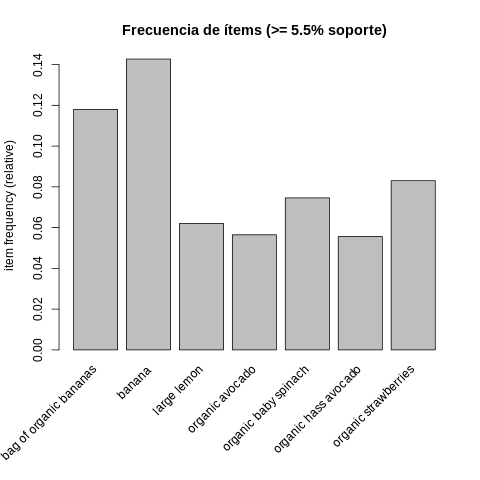

In [ ]:
%%R -o r_execution_time,rules_df
# Cargar el paquete arules
if (!require("arules")) {
    install.packages("arules", repos="http://cran.us.r-project.org")
    library(arules)
}

# Leer las transacciones desde el archivo exportado por Python
baskets <- read.transactions("TransactionsInstacart.csv", sep = ",", format = "basket")

# Visualizar la frecuencia de ítems
itemFrequencyPlot(baskets, support = 0.055, main = "Frecuencia de ítems (>= 5.5% soporte)")
start_r_time <- Sys.time()

# Generar reglas de asociación con Apriori
rules_r <- apriori(baskets, parameter = list(support = 0.001, confidence = 0.3, minlen = 2, maxlen = 15))
rules_r <- sort(rules_r, by = "lift")

# Detener el cronómetro
end_r_time <- Sys.time()
r_execution_time <- end_r_time - start_r_time
print(paste("Tiempo total de procesamiento en R:", r_execution_time, "segundos"))

# Inspeccionar las primeras reglas
inspect(rules_r[1:5])

# Convertir las reglas en un data.frame y añadir columnas
rules_df <- as(rules_r, "data.frame")
rules_df$antecedent <- labels(lhs(rules_r))  # Extrae el lado izquierdo (lhs)
rules_df$consequent <- labels(rhs(rules_r))  # Extrae el lado derecho (rhs)

# Exportar a un archivo CSV
write.csv(rules_df, file = "rulesdatabase_r.csv", row.names = FALSE, quote = TRUE)


In [ ]:
import os #se utiliza aquí para verificar si un archivo (rulesdatabase_r.csv) existe en el sistema de archivos.


# Verifica si el archivo generado por R está disponible
if os.path.exists("rulesdatabase_r.csv"):
    # Cargar las reglas generadas por R/arules
    rules_r_df = pd.read_csv("rulesdatabase_r.csv")
    rules_r_df.sort_values(by="lift", ascending=False, inplace=True)
    rules_r_df.reset_index(drop=True, inplace=True)
    print("\nReglas generadas por R (primeras 5):")
    print(rules_r_df.head())
else:
    print("El archivo 'rulesdatabase_r.csv' no se encontró. Asegúrate de haber generado las reglas en R.")



Reglas generadas por R (primeras 5):
                                               rules   support  confidence  \
0  {strawberry rhubarb yoghurt} => {blueberry yog...  0.001197    0.309665   
1  {blueberry yoghurt} => {strawberry rhubarb yog...  0.001197    0.310277   
2  {nonfat icelandic style strawberry yogurt} => ...  0.001166    0.422652   
3  {non fat acai ~ mixed berries yogurt} => {icel...  0.001288    0.402381   
4  {icelandic style skyr blueberry non~fat yogurt...  0.001677    0.312057   

   coverage       lift  count  \
0  0.003864  80.298014    157   
1  0.003856  80.298014    157   
2  0.002759  78.660621    153   
3  0.003201  74.887947    169   
4  0.005373  71.084466    220   

                                        antecedent  \
0                     {strawberry rhubarb yoghurt}   
1                              {blueberry yoghurt}   
2       {nonfat icelandic style strawberry yogurt}   
3            {non fat acai ~ mixed berries yogurt}   
4  {icelandic style skyr

In [ ]:
# Cargar las reglas generadas desde R
rules_r = pd.read_csv("rulesdatabase_r.csv")

Comparación de las reglas generadas

In [ ]:
def comparar_reglas(rules_py, rules_ml, rules_r):
    """
    Compara reglas generadas manualmente, con mlxtend, y en R.
    """
    # Normalizar `rules_mlxtend`: convertir `antecedents` y `consequents` de conjuntos a listas ordenadas
    rules_ml['antecedents'] = rules_ml['antecedents'].apply(lambda x: sorted(list(x)) if isinstance(x, set) else x)
    rules_ml['consequents'] = rules_ml['consequents'].apply(lambda x: sorted(list(x)) if isinstance(x, set) else x)

    # `rules_r` ya tiene las columnas correctas: `antecedent` y `consequent`
    matches = []
    differences = []

    for _, rule_py in rules_py.iterrows():
        # Buscar regla equivalente en `mlxtend`
        matched_ml = rules_ml[
            (rules_ml['antecedents'] == sorted(rule_py['antecedent'])) &
            (rules_ml['consequents'] == sorted(rule_py['consequent']))
        ]

        # Buscar regla equivalente en `R`
        matched_r = rules_r[
            (rules_r['antecedent'] == sorted(rule_py['antecedent'])) &
            (rules_r['consequent'] == sorted(rule_py['consequent']))
        ]

        if not matched_ml.empty and not matched_r.empty:
            matched_ml_row = matched_ml.iloc[0]
            matched_r_row = matched_r.iloc[0]
            matches.append({
                'antecedent': rule_py['antecedent'],
                'consequent': rule_py['consequent'],
                'support_manual': rule_py['support'],
                'support_ml': matched_ml_row['support'],
                'support_r': matched_r_row['support'],
                'confidence_manual': rule_py['confidence'],
                'confidence_ml': matched_ml_row['confidence'],
                'confidence_r': matched_r_row['confidence'],
                'lift_manual': rule_py['lift'],
                'lift_ml': matched_ml_row['lift'],
                'lift_r': matched_r_row['lift']
            })
        else:
           # Si la regla no está en una o más implementaciones
            differences.append({
                'antecedent': rule_py['antecedent'],
                'consequent': rule_py['consequent'],
                'reason': 'No encontrada en mlxtend o R'
            })

    return pd.DataFrame(matches), pd.DataFrame(differences)



In [ ]:
# Recopilar datos


resultados = [
    {
        "Reglas generadas": len(rules_manual),  # Número de reglas generadas manualmente
        "Soporte mínimo": "1%",
        "Confianza promedio": round(rules_manual["confidence"].mean(), 2),  # Promedio de confianza en reglas manuales
        "Lift promedio": round(rules_manual["lift"].mean(), 2),  # Promedio de lift en reglas manuales
        "Tiempo (Python manual)": round(manual_time, 2),  # Tiempo total calculado para la implementación manual
        "Tiempo (`mlxtend`)": round(mlxtend_time, 2),    # Tiempo total calculado con mlxtend
        "Tiempo (R)": round(float(r_execution_time[0]), 2),  # Tiempo calculado en R (convertido a segundos)



    },
]

# Crear un DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

# Visualizar la tabla
print("\nTabla comparativa de tiempos y resultados:")
from IPython.display import display
display(df_resultados)



Tabla comparativa de tiempos y resultados:


,Reglas generadas,Soporte mínimo,Confianza promedio,Lift promedio,Tiempo (Python manual),Tiempo (`mlxtend`),Tiempo (R)
0,3,1%,0.32,3.05,393.19,93.89,1.87


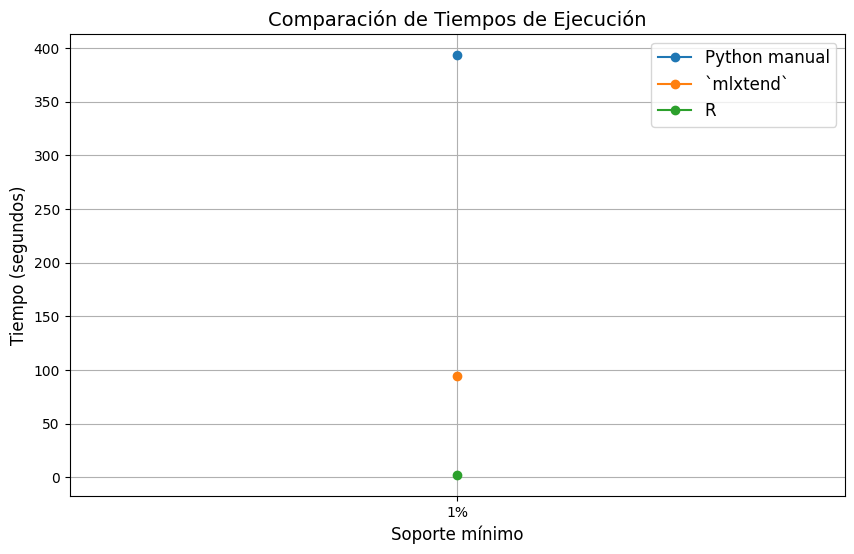

In [ ]:
# Datos para el gráfico
soportes = df_resultados["Soporte mínimo"]
tiempos_python = df_resultados["Tiempo (Python manual)"]
tiempos_mlxtend = df_resultados["Tiempo (`mlxtend`)"]
tiempos_r = df_resultados["Tiempo (R)"]
confianza_prom = df_resultados["Confianza promedio"]
lift_prom = df_resultados["Lift promedio"]
reglas_generadas = df_resultados["Reglas generadas"]

# Gráfico 1: Comparación de tiempos
plt.figure(figsize=(10, 6))
plt.plot(soportes, tiempos_python, label="Python manual", marker="o")
plt.plot(soportes, tiempos_mlxtend, label="`mlxtend`", marker="o")
plt.plot(soportes, tiempos_r, label="R", marker="o")
plt.title("Comparación de Tiempos de Ejecución", fontsize=14)
plt.xlabel("Soporte mínimo", fontsize=12)
plt.ylabel("Tiempo (segundos)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Generación de Recomendaciones Basadas en una Transacción Existente

In [ ]:
print(rules_df.columns)
print(rules_df.head())


Index(['rules', 'support', 'confidence', 'coverage', 'lift', 'count',
       'antecedent', 'consequent'],
      dtype='object')
                                                rules   support  confidence  \
15  {strawberry rhubarb yoghurt} => {blueberry yog...  0.001197    0.309665   
14  {blueberry yoghurt} => {strawberry rhubarb yog...  0.001197    0.310277   
4   {nonfat icelandic style strawberry yogurt} => ...  0.001166    0.422652   
8   {non fat acai ~ mixed berries yogurt} => {icel...  0.001288    0.402381   
22  {icelandic style skyr blueberry non~fat yogurt...  0.001677    0.312057   

    coverage       lift  count  \
15  0.003864  80.298014    157   
14  0.003856  80.298014    157   
4   0.002759  78.660621    153   
8   0.003201  74.887947    169   
22  0.005373  71.084466    220   

                                         antecedent  \
15                     {strawberry rhubarb yoghurt}   
14                              {blueberry yoghurt}   
4        {nonfat icelandic 

In [ ]:
# Función para convertir una cadena del antecedente a lista (si es necesario)
def convertir_a_lista(cadena):
    cadena = cadena.strip("{}")
    if not cadena:
        return []
    return [item.strip() for item in cadena.split(',')]

# Función para evaluar coincidencia parcial
def coincide_parcial(antecedente, transaccion, umbral=0.5):
    # Retorna True si al menos "umbral" (por defecto 50%) de los ítems del antecedente están en la transacción
    if not antecedente:
        return False
    interseccion = set(antecedente).intersection(set(transaccion))
    return len(interseccion) / len(antecedente) >= umbral


Usando la transacción existente en el índice 500: ['organic large extra fancy fuji apple', 'organic strawberries', 'organic sweet vanilla bean nutrition complete protein shake', 'classic peanut butter', 'seedless red grapes', 'smoked maple ham', 'chocolate mint builder~s bar', 'reduced fat midnight chocolate milk', 'vanilla skyr style yogurt', 'chocolate brownie flavor protein bar', 'organic strawberry smoothie', 'organic creamy chocolate fudge nutritional shake', 'organic cucumber', 'organic grape tomatoes', 'original bagel crisps roasted garlic', 'sweet onions', 'red vine tomato', 'lowfat small curd cottage cheese', 'european style salted butter']
Productos recomendados basados en la transacción existente:
                   producto      lift  confidence   support
0    {organic hass avocado}  5.940453    0.330189  0.001067
4             {large lemon}  5.428922    0.336595  0.001311
5         {organic avocado}  5.340445    0.301560  0.001326
6    {organic strawberries}  4.828762    0

In [ ]:
# Seleccionar una transacción existente por indice
indice_transaccion = 301  # Modifica este valor para probar con distintos índices
transaccion_existente = transactions[indice_transaccion]
print(f"Usando la transacción existente en el índice {indice_transaccion}: {transaccion_existente}")

# Filtrar reglas (obtenidas desde R y almacenadas en 'rules_df') usando el criterio de coincidencia parcial
productos_recomendados = []
for _, regla in rules_df.iterrows():
    # Convertir el antecedente (si viene como cadena) a una lista de ítems
    antecedente = convertir_a_lista(regla['antecedent'])
    # Se evalúa la coincidencia parcial: al menos el 50% de los ítems del antecedente deben estar en la transacción
    if coincide_parcial(antecedente, transaccion_existente, umbral=0.5):
        productos_recomendados.append({
            'producto': regla['consequent'],
            'lift': regla['lift'],
            'confidence': regla['confidence'],
            'support': regla['support']
        })

# Convertir la lista de recomendaciones a un DataFrame definiendo las columnas esperadas
import pandas as pd
columnas = ['producto', 'lift', 'confidence', 'support']
recomendaciones_df = pd.DataFrame(productos_recomendados, columns=columnas)

# Verificar si se encontraron recomendaciones
if recomendaciones_df.empty:
    print("No se encontraron recomendaciones para esta transacción.")
else:
    # Eliminar duplicados y ordenar las recomendaciones por 'lift'
    recomendaciones_df = recomendaciones_df.drop_duplicates(subset='producto').sort_values(by='lift', ascending=False)
    print("Productos recomendados basados en la transacción existente:")
    print(recomendaciones_df.head())


Usando la transacción existente en el índice 301: ['asparagus', 'unsweetened coconut milk beverage', 'boneless skinless chicken breast fillets', 'mozzarella ciliegine fresh', 'red vine tomato', 'simple favorites chicken enchilada suiza', 'fridge pack cola', 'chardonnay', 'total 2~ with strawberry lowfat greek strained yogurt', 'orange chicken', 'simple favorites five cheese rigatoni', 'brussels sprouts', 'red delicious apple']
Productos recomendados basados en la transacción existente:
                   producto      lift  confidence   support
0             {large lemon}  6.575351    0.407674  0.001296
1  {bag of organic bananas}  3.571662    0.421384  0.001021
4                  {banana}  2.321608    0.331337  0.001265


In [ ]:
# Visualización interactiva con Plotly
import plotly.express as px
fig = px.scatter(
    recomendaciones_df,
    x='support',
    y='confidence',
    size='lift',
    color='lift',
    hover_data=['producto'],
    title=f"Productos Recomendados Basados en Transacción Existente (Índice {indice_transaccion})"
)
fig.update_layout(
    xaxis_title="Soporte",
    yaxis_title="Confianza",
    legend_title="Lift",
    template="plotly_dark"
)
fig.show()

# Grafo interactivo con la transacción existente
import networkx as nx
import plotly.graph_objects as go

# Crear grafo para la transacción existente
G = nx.Graph()

# Añadir nodos para la transacción inicial
for producto in transaccion_existente:
    G.add_node(producto, type='comprado', color='blue', size=30)

# Añadir nodos para las recomendaciones
for _, row in recomendaciones_df.iterrows():
    G.add_node(row['producto'], type='recomendado', color='orange', size=row['lift']*10)
    for producto in transaccion_existente:
        G.add_edge(producto, row['producto'], weight=row['lift'])

# Extraer posiciones para los nodos
pos = nx.spring_layout(G)

# Nodos del grafo
node_x = []
node_y = []
node_size = []
node_color = []
node_text = []
for node in G.nodes(data=True):
    node_x.append(pos[node[0]][0])
    node_y.append(pos[node[0]][1])
    node_size.append(node[1]['size'])
    node_color.append(node[1]['color'])
    node_text.append(node[0])

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    marker=dict(size=node_size, color=node_color, line=dict(width=1)),
    text=node_text,
    hoverinfo='text'
)

# Conexiones del grafo
edge_x = []
edge_y = []
for edge in G.edges(data=True):
    edge_x.extend([pos[edge[0]][0], pos[edge[1]][0], None])
    edge_y.extend([pos[edge[0]][1], pos[edge[1]][1], None])

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Visualización interactiva del grafo
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=f"Red Interactiva de Productos Comprados y Recomendados (Transacción Existente, Índice {indice_transaccion})",
                    showlegend=False,
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))
fig.show()


GRÁFICOS